# Student Matcher

# Inhalt
1. Ähnlichkeitsberechnung \
  1.1 Verschiedene Metriken zur Ähnlichkeitsberechnung \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.1 Ähnlichkeitsberechnung mit Euklidischer Distanz, Manhattan-Distanz und Kosinus-Ähnlichkeit \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.2 Vergleich der Metriken \
  1.2 Stichprobenartige Überprüfung der Ergebnisse der verschiedenen Metriken \
  1.3 Vergleich der Paare der Ähnlichkeitsberechnung und der Cluster aus der Clusteranalyse \
  1.4 Auswahl der Metrik
2. Netzwerk-Analyse \
  2.1 Netzwerk aus den Paaren mit den höchsten Ähnlichkeiten erstellen \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.1 Nodes je nach Cluster färben \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.2 Netzwerk ausgeben
3. Student Matcher Anwendung

In [506]:
%store -r columns_encoded
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded
%store -r pseudonym_df

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

pseudonym_df = pseudonym_df

In [507]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import networkx as nx

import math

# 1. Ähnlichkeitsberechnung

# 1.1 Verschiedene Metriken zur Ähnlichkeitsberechnung

Um die richtige Metrik für die Berechnung der Ähnlichkeit zu finden, wurden drei bekannte Metriken zur Abstands- bzw. Ähnlichkeitsberechnung gegeinander abgewogen: Die euklidische Distanz, die Manhattan-Distanz und die Kosinus-Ähnlichkeit.

Erwartet wurde, dass die Manhattan-Distanz aufgrund der hohen Dimensionalität besser abschneidet, als die Euklidische Distanz (siehe https://bib.dbvis.de/uploadedFiles/155.pdf). Da für die Berechnung der Kosinus-Ähnlichkeit die Vektorlänge (also die Höhe der Werte der Features) nicht so relevant ist wie für die beiden anderen Metriken (siehe https://medium.com/@kunal_gohrani/different-types-of-distance-metrics-used-in-machine-learning-e9928c5e26c7), die Ähnlichkeit bzw. Nichtähnlichkeit der Daten im Datensatz aber von diesen Wertunterschieden abhängt, wurde von der Kosinus-Ähnlichkeit eine schlechtere Performance erwartet als von der Manhattan-Distanz.

Um die Performance der Metriken zu vergleichen, wird die Ähnlichkeitsberechnung je einmal mit jeder Metrik durchgeführt und anschließend die Ergebnisse verglichen.

In [508]:
# rename column in pseudonym_df to access it easier later
pseudonym_df = pd.DataFrame(pseudonym_df)
pseudonym_df.rename(columns={'Bitte gib hier ein Pseudonym ein und merke dir dieses (z.B. Kürzel, Zahlencode, etc.). Damit können nach Abschluss des Projektes der eigene "Datenpunkt" gefunden werden. Das Pseudonym wird für Andere sichtbar sein.': 'pseudonym'}, inplace=True)

In [509]:
# allowed values for metric: "euclidean", "manhattan", "cosine"
def compute_similarities_with_metric(metric):
    # Compute pairwise distances (or similarities in case of cosine similarity)
    if(metric == "cosine"):
        distances = cosine_similarity(data_encoded) # not actually distances, but rather similarities
    else:
        distances = pairwise_distances(data_encoded, metric=metric)

    # Convert to dataframe
    distances_df = pd.DataFrame(distances, index=pseudonym_df.pseudonym, columns=pseudonym_df.pseudonym)
    distances_df = distances_df.rename_axis('person1', axis=0).rename_axis('person2', axis=1)
    distances_df = distances_df.where(np.triu(np.ones(distances_df.shape)).astype(bool))
    distances_df = distances_df.stack().reset_index().rename(columns={0: 'distance'})

    # Drop self-comparisons
    distances_df = distances_df[distances_df['person1'] != distances_df['person2']]

    similarities_df = distances_df.copy().rename(columns={'distance': 'similarity_' + metric})

    # Convert distances to similarity scores (not needed for cosine similarity)
    if(metric != "cosine"):
        scaled_similarities = MinMaxScaler().fit_transform(similarities_df[['similarity_' + metric]])
        similarities_df['similarity_' + metric] = 1 - scaled_similarities
        
    # Sort by similarity
    similarities_df.sort_values(by='similarity_' + metric, ascending=False, inplace=True)

    return similarities_df

### 1.1.1 Ähnlichkeitsberechnung mit Euklidischer Distanz, Manhattan-Distanz und Kosinus-Ähnlichkeit

In [510]:
# Drop age, which should not used for comparison
data_encoded = data_encoded.drop(["Alter"], axis=1)

# Compute similarities with different metrics
similarities_manhattan = compute_similarities_with_metric("manhattan")
similarities_euclidean = compute_similarities_with_metric("euclidean")
similarities_cosine = compute_similarities_with_metric("cosine")

print(similarities_manhattan.head())
print("\n-----------------------------\n")
print(similarities_euclidean.head())
print("\n-----------------------------\n")
print(similarities_cosine.head())

                     person1  person2  similarity_manhattan
901                      123     asdf              1.000000
433  air-oughtest-wood-abate   ac1306              0.806452
109                    hbstr      DRP              0.774194
432  air-oughtest-wood-abate  agalper              0.774194
687               bangnon123    7bpf8              0.758065

-----------------------------

                     person1               person2  similarity_euclidean
901                      123                  asdf              1.000000
109                    hbstr                   DRP              0.857330
432  air-oughtest-wood-abate               agalper              0.822508
687               bangnon123                 7bpf8              0.814101
70                     hbstr  Quantum342 (ChatGPT)              0.805804

-----------------------------

                     person1  person2  similarity_cosine
901                      123     asdf           0.982645
687               bangno

### 1.1.2 Vergleich der Metriken

Für den Vergleich der Metriken wurden zunächst für jede Metrik die 10 Paare von Befragten mit der höchsten errechneten Ähnlichkeit ermittelt. Diese Paare wurden dann in einem gemeinsamen Dataframe dargestellt, um Überschneidungen oder Unterschiede zwischen den verschiedenen Ähnlichkeitsberechnungen zu finden.

In [511]:
# append pseudonym to data_encoded
data_encoded["Pseudonym"] = pseudonym_df

In [512]:
# get the highest similarities for each metric
highest_similarities_cosine = similarities_cosine.sort_values(by='similarity_cosine', ascending=False).head(10)
highest_similarities_manhattan = similarities_manhattan.sort_values(by='similarity_manhattan', ascending=False).head(10)
highest_similarities_euclidean = similarities_euclidean.sort_values(by='similarity_euclidean', ascending=False).head(10)

In [513]:
# compare top 10 most similar students for each similarity metric
top_10_comparison = pd.merge(highest_similarities_manhattan, highest_similarities_euclidean, how="outer", on=["person1", "person2"])
top_10_comparison = pd.merge(top_10_comparison, highest_similarities_cosine, how="outer", on=["person1", "person2"])

top_10_comparison.fillna("not in top 10", inplace=True)

top_10_comparison

,person1,person2,similarity_manhattan,similarity_euclidean,similarity_cosine
0,123,asdf,1.0,1.0,0.982645
1,air-oughtest-wood-abate,ac1306,0.806452,0.805804,0.959881
2,hbstr,DRP,0.774194,0.85733,0.964293
3,air-oughtest-wood-abate,agalper,0.774194,0.822508,0.962987
4,bangnon123,7bpf8,0.758065,0.814101,0.967842
5,Ismail,eprotizu,0.725806,0.765829,not in top 10
6,lalala-lololo,FB42,0.725806,0.765829,not in top 10
7,Lm1711,Mk27,0.709677,not in top 10,not in top 10
8,hbstr,Quantum342 (ChatGPT),0.709677,0.805804,0.957658
9,hbstr,7bpf8,0.709677,0.773635,not in top 10


Es zeigt sich, dass Manhattan-Distanz und euklidische Distanz sehr ähnliche Werte für die 10 Paare mit der höchsten Ähnlichkeit liefern. Lediglich je ein Paar ist nicht in der Top-10 der jeweils anderen Metrik enthalten. Die Kosinus-Ähnlichkeit liefert hingegen neben einigen Überschneidungen auch Paare, die mit den beiden anderen Metriken nicht unter den Top-10 sind. Welche der Metriken nun tatsächlich bessere Ergebnisse liefert, soll mit Stichproben aus den Top-10 abgeschätzt werden.

## 1.2 Stichprobenartige Überprüfung der Ergebnisse der verschiedenen Metriken

Die Befragten mit den Pseudonymen "123" und "asdf" sind mit allen Metriken das ähnlichste Paar. Daher sollen sie zunächst einmal genauer verglichen werden:

In [514]:
asdf_and_123 = data_encoded.loc[(data_encoded["Pseudonym"] == "123") | (data_encoded["Pseudonym"] == "asdf")]
asdf_and_123

,Als wie sportlich würdest du dich einschätzen?,Welche Rolle spielt für dich gesunde Ernährung?,Wie gerne gehst du Essen oder Trinken?,Wie gerne kochst du selbst?,Wie gerne gehst du feiern?,Wie sehr interessierst du dich für Musik?,Wie gerne liest Du?,"Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?","Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?","Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?",...,Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Genre Lieblingsmusiker Alternative? (encoded),Genre Lieblingsmusiker Electro? (encoded),Genre Lieblingsmusiker Kein Lieblingsgenre? (encoded),Genre Lieblingsmusiker Pop? (encoded),Genre Lieblingsmusiker Rap Hip Hop? (encoded),Genre Lieblingsmusiker Rock? (encoded),Geschlecht (weiblich?),Pseudonym
16,3,3,4,3,4,4,5,4,4,4,...,0,1,0,0,0,0,1,0,1,123
45,3,3,4,3,4,4,4,4,4,3,...,0,1,0,0,0,0,1,0,1,asdf


In [516]:
asdf_and_123_differences = asdf_and_123.drop("Pseudonym", axis=1).diff().T.rename(columns={45: "diff"}).drop(16, axis=1)
asdf_and_123_differences[asdf_and_123_differences["diff"] > 0]

,diff
Wie häufig nutzt du soziale Medien?,1.0
Wie … schätzt Du dich selbst ein? (1 gar nicht - 5\nsehr) [glücklich],1.0
"Hattest du schon einmal Zweifel daran, ob du dein Studium\nschaffen kannst?",2.0


Es zeigt sich, dass die beiden Befragten lediglich in drei Features Unterschiede aufweisen. In zwei davon ist der Unterschied sogar nur eins auf einer Skala von 1-5, in einem Feature ist er immerhin zwei. Die Befragten scheinen sich also - soweit aus den Daten zu interpretieren - tatsächlich sehr ähnlich zu sein.

Die Befragten mit den Pseudonymen "123" und "Ysaja" sind eins der Paare, die nur mit der Kosinus-Ähnlichkeit in den Top-10 landen. Daher sollen sie auch etwas genauer verglichen werden:

In [533]:
Ysaja_and_123 = data_encoded.loc[(data_encoded["Pseudonym"] == "123") | (data_encoded["Pseudonym"] == "Ysaja")]
Ysaja_and_123

,Als wie sportlich würdest du dich einschätzen?,Welche Rolle spielt für dich gesunde Ernährung?,Wie gerne gehst du Essen oder Trinken?,Wie gerne kochst du selbst?,Wie gerne gehst du feiern?,Wie sehr interessierst du dich für Musik?,Wie gerne liest Du?,"Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?","Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?","Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?",...,Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Genre Lieblingsmusiker Alternative? (encoded),Genre Lieblingsmusiker Electro? (encoded),Genre Lieblingsmusiker Kein Lieblingsgenre? (encoded),Genre Lieblingsmusiker Pop? (encoded),Genre Lieblingsmusiker Rap Hip Hop? (encoded),Genre Lieblingsmusiker Rock? (encoded),Geschlecht (weiblich?),Pseudonym
16,3,3,4,3,4,4,5,4,4,4,...,0,1,0,0,0,0,1,0,1,123
43,2,4,5,5,4,5,3,4,3,3,...,0,1,0,0,0,0,0,0,1,Ysaja


In [534]:
Ysaja_and_123_differences = Ysaja_and_123.drop("Pseudonym", axis=1).diff().T.rename(columns={43: "diff"}).drop(16, axis=1)
Ysaja_and_123_differences[Ysaja_and_123_differences["diff"] > 0]

,diff
Welche Rolle spielt für dich gesunde Ernährung?,1.0
Wie gerne gehst du Essen oder Trinken?,1.0
Wie gerne kochst du selbst?,2.0
Wie sehr interessierst du dich für Musik?,1.0
Wie häufig nutzt du soziale Medien?,1.0
Wie … schätzt Du dich selbst ein? (1 gar nicht - 5\nsehr) [verwirrt],1.0
Wie … schätzt Du dich selbst ein? (1 gar nicht - 5\nsehr) [geduldig],1.0
Wie zufrieden bist du mit deinem Studium?,1.0
"Prokrastinierst du, wenn du lernen müsstest?",1.0
Wie häufig machst du Abgaben auf den letzten Drücker?,1.0


Es zeigt sich, dass die beiden Befragten sich zwar in einigen Features unterscheiden, allerdings oft nur um eine Position auf der Skala von 1-5.

Als Vergleich dazu sollen nun noch zwei Befragte verglichen werden, die bei der euklidischen Distanz und der Manhattan-Distanz in den Top-10 landen, bei der Kosinus-Ähnlichkeit aber nicht:

In [542]:
hbstr_and_7bpf8 = data_encoded.loc[(data_encoded["Pseudonym"] == "hbstr") | (data_encoded["Pseudonym"] == "7bpf8")]
hbstr_and_7bpf8

,Als wie sportlich würdest du dich einschätzen?,Welche Rolle spielt für dich gesunde Ernährung?,Wie gerne gehst du Essen oder Trinken?,Wie gerne kochst du selbst?,Wie gerne gehst du feiern?,Wie sehr interessierst du dich für Musik?,Wie gerne liest Du?,"Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?","Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?","Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?",...,Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Genre Lieblingsmusiker Alternative? (encoded),Genre Lieblingsmusiker Electro? (encoded),Genre Lieblingsmusiker Kein Lieblingsgenre? (encoded),Genre Lieblingsmusiker Pop? (encoded),Genre Lieblingsmusiker Rap Hip Hop? (encoded),Genre Lieblingsmusiker Rock? (encoded),Geschlecht (weiblich?),Pseudonym
1,3,4,4,5,2,4,2,3,4,4,...,1,1,0,0,0,0,0,1,0,hbstr
21,3,4,5,4,4,3,2,2,4,3,...,0,1,0,0,0,1,0,0,0,7bpf8


In [543]:
hbstr_and_7bpf8_differences = hbstr_and_7bpf8.drop("Pseudonym", axis=1).diff().T.rename(columns={21: "diff"}).drop(1, axis=1)
hbstr_and_7bpf8_differences[hbstr_and_7bpf8_differences["diff"] > 0]

,diff
Wie gerne gehst du Essen oder Trinken?,1.0
Wie gerne gehst du feiern?,2.0
Wie sehr interessierst du dich für Videospiele?,1.0
Würdest du dich selbst als introvertiert/extrovertiert\nbezeichnen?,1.0
"Hast du häufig Angst etwas zu verpassen, wenn du nicht\nunter Menschen bist?",1.0
Wie … schätzt Du dich selbst ein? (1 gar nicht - 5\nsehr) [verwirrt],1.0
Wie … schätzt Du dich selbst ein? (1 gar nicht - 5\nsehr) [geduldig],2.0
Wie gerne magst du Sprachnachrichten?,1.0
Interesse an Basketball? (encoded),1.0
Interesse an Football? (encoded),1.0


Das Ergebnis sieht hier recht ähnlich aus, wie das vorherige. Es sind also in dieser Stichprobe zunächst keine klaren Unterschiede in der Ähnlichkeitsberechnung mit unterschiedlichen Metriken zu erkennen.

## 1.3 Vergleich der Paare der Ähnlichkeitsberechnung und der Cluster aus der Clusteranalyse

In [519]:
# get the best cluster analysis results
%store -r data_original_reduced_tsne_hc

In [520]:
cluster = data_original_reduced_tsne_hc.copy()
cluster = cluster.drop(columns=["Hyperparameter1", "Hyperparameter2"])
cluster["Pseudonym"] = pseudonym_df

,Cluster,Pseudonym
0,0,lalala-lololo
1,0,hbstr
2,2,Panda
3,2,TomTom Navigation
4,2,LcAbrgr
...,...,...
57,0,Stempelliebhaber
58,2,Fel
59,0,PaBe28
60,0,oretani


In [521]:
# append clusters of person1 and person2 to top_10_comparison
top_10_comparison_and_clusters = top_10_comparison.merge(cluster, left_on="person1", right_on="Pseudonym").rename(columns={"Cluster": "cluster_person1"}).drop("Pseudonym", axis=1)
top_10_comparison_and_clusters = top_10_comparison_and_clusters.merge(cluster, left_on="person2", right_on="Pseudonym").rename(columns={"Cluster": "cluster_person2"}).drop("Pseudonym", axis=1)
top_10_comparison_and_clusters

,person1,person2,similarity_manhattan,similarity_euclidean,similarity_cosine,cluster_person1,cluster_person2
0,123,asdf,1.0,1.0,0.982645,0,0
1,123,Ysaja,not in top 10,not in top 10,0.959932,0,0
2,123,oretani,not in top 10,not in top 10,0.955469,0,0
3,air-oughtest-wood-abate,ac1306,0.806452,0.805804,0.959881,2,2
4,air-oughtest-wood-abate,agalper,0.774194,0.822508,0.962987,2,0
5,hbstr,DRP,0.774194,0.85733,0.964293,0,0
6,7bpf8,DRP,not in top 10,0.781532,not in top 10,1,0
7,hbstr,Quantum342 (ChatGPT),0.709677,0.805804,0.957658,0,0
8,hbstr,7bpf8,0.709677,0.773635,not in top 10,0,1
9,bangnon123,7bpf8,0.758065,0.814101,0.967842,1,1


Es zeigt sich, dass insgesamt recht viele der Paare mit hohen berechneten Ähnlichkeitswerten im gleichen Cluster liegen. Das spricht für eine gute Ähnlichkeitsberechnung bzw. andersherum für ein gutes Clustering. Allerdings ist kein Unterschied zwischen den einzelnen Metriken zu erkennen.

## 1.4 Auswahl der Metrik

Da weder in der stichprobenartigen Auswertung der Ergebnisse der einzelnen Ähnlichkeitsberechnungen noch im Vergleich mit den Ergebnissen der Clusteranalyse eine Metrik besonders positiv oder besonders negativ aufgefallen ist, wird für das weitere Vorgehen die Manhattan-Distanz verwendet.

# 2. Netzwerk-Analyse

Für die Netzwerkanalyse wird zunächst ein Schwellwert festgelegt, über dem ein Paar als "besonders ähnlich" gilt. Als Referenz dafür wurden die obersten 2% der höchsten Ähnlichkeiten verwendet.

In [564]:
# get the top 2% of the most similar students
top_2_percent_of_similarities = similarities_manhattan.head(int(len(similarities_manhattan)*(2/100)))
top_2_percent_of_similarities

,person1,person2,similarity_manhattan
901,123,asdf,1.000000
433,air-oughtest-wood-abate,ac1306,0.806452
109,hbstr,DRP,0.774194
432,air-oughtest-wood-abate,agalper,0.774194
687,bangnon123,7bpf8,0.758065
629,Ismail,eprotizu,0.725806
20,lalala-lololo,FB42,0.725806
82,hbstr,7bpf8,0.709677
1825,Lm1711,Mk27,0.709677
70,hbstr,Quantum342 (ChatGPT),0.709677


## 2.1 Netzwerk aus den Paaren mit den höchsten Ähnlichkeiten erstellen

Aus den berechneten Paaren mit den höchsten Ähnlichkeiten wird im ersten Schritt ein Graph erstellt. Anschließend werden die Befragten, die nicht in diesen vorkommen, als Nodes hinzugefügt.

In [565]:
edges = top_2_percent_of_similarities.rename(columns={'person1': 'source', 'person2': 'target', 'similarity_manhattan': 'weight'})

G = nx.from_pandas_edgelist(edges, edge_attr=True)

In [568]:
people_not_yet_in_network = list(set(data_encoded.Pseudonym) - set(G.nodes()))

G.add_nodes_from(people_not_yet_in_network)

### 2.1.1 Nodes je nach Cluster färben

Um die Ergebnisse der Clusteranalyse mit den berechneten Ähnlichkeiten vergleichen zu können, werden die Nodes je nach Cluster unterschiedlich eingefärbt.

In [ ]:
cluster_indexed = cluster.set_index("Pseudonym")
cluster_indexed

In [ ]:
node_color_map = []
for node in G.nodes():
    if cluster_indexed.loc[node].Cluster == 0:
        node_color_map.append('orchid')
    elif cluster_indexed.loc[node].Cluster == 1:
        node_color_map.append('mediumturquoise')
    else:
        node_color_map.append('cornflowerblue')

### 2.1.2 Netzwerk ausgeben

Das Netzwerk wird als Grafik ausgegeben. Dabei werden die Verbindungen anhand des zu ihnen gehörenden Ähnlichkeitswertes unterschiedlich eingefärbt.

C:\Users\Janne\AppData\Local\Temp\ipykernel_20400\2348819850.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Similarity of nodes of connection")


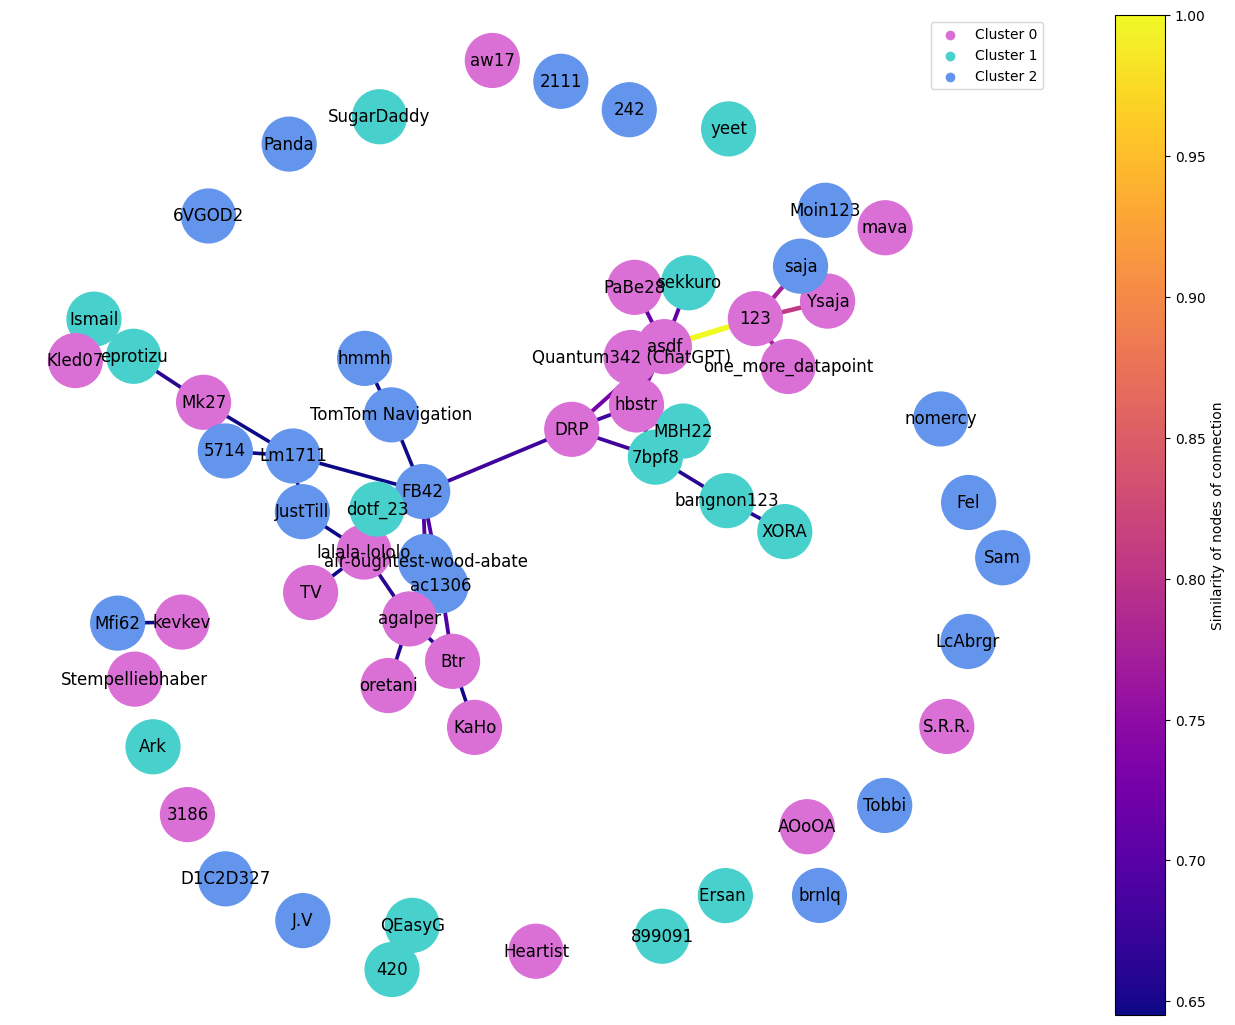

In [570]:
plt.figure(3, figsize=(13,10))

pos = nx.layout.spring_layout(G, k=0.2, seed=421)
vmin = edges["weight"].min()
vmax = edges["weight"].max()
cmap = plt.cm.plasma

nx.draw(G, with_labels=True, edge_cmap=cmap, edge_color=edges["weight"], vmin=vmin, vmax=vmax,
        width=edges["weight"]* 4, node_color=node_color_map, node_size=1500, pos=pos)

# draw a colorbar for the edge weights/similarities
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, label="Similarity of nodes of connection")

# create an empty plot with color and label for each cluster to fake the legend 
# since nx.draw does not support a legend
for v in range(3):
        plt.scatter([],[], label='Cluster {}'.format(v))
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legend_handles[0].set_color('orchid')
leg.legend_handles[1].set_color('mediumturquoise')
leg.legend_handles[2].set_color('cornflowerblue')

plt.show()

Es lässt sich ein Zusammenhang der Ergebnisse der Cluster-Analyse und der berechneten Ähnlichkeiten erkennen: Nodes aus einem gemeinsamen Cluster haben tendenziell mehr Verbindungen zueinander als zu Nodes aus einem anderen Cluster. Außerdem finden sich die stärksten Ähnlichkeiten unter Nodes eines Clusters.

# 3. Student Matcher Anwendung

Die hier bereitgestellte Funktion berechnet für ein übergebenes Pseudonym die fünf am besten passenden anderen Pseudonyme.

In [573]:
def student_matcher(pseudonym):
    mask_pseudo = similarities_manhattan.person1 == pseudonym
    if len(similarities_manhattan[mask_pseudo]) <= 0:
        print("Für das übergebene Pseudonym wurde leider kein passender Datenpunkt gefunden.")
        return
    
    df_matches = similarities_manhattan[mask_pseudo].sort_values("similarity_manhattan", ascending=False)
    print("Für die gesuchte Personen wurden die folgenden Personen gefunden, die zu ihr passen könnten:\n")
    print(df_matches.iloc[0:5]["person2"])

    return df_matches.iloc[0:5]

In [574]:
student_matcher("lalala-lololo")

Für die gesuchte Personen wurden die folgenden Personen gefunden, die zu ihr passen könnten:

20        FB42
51          TV
26     agalper
56    JustTill
19     dotf_23
Name: person2, dtype: object


,person1,person2,similarity_manhattan
20,lalala-lololo,FB42,0.725806
51,lalala-lololo,TV,0.677419
26,lalala-lololo,agalper,0.677419
56,lalala-lololo,JustTill,0.645161
19,lalala-lololo,dotf_23,0.645161
